<a href="https://colab.research.google.com/github/Edwin10151/MachineLearning/blob/main/JunkClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## JunkFood Classification
Identify whether the food is junk food or healthy food in the form of image

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import io
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2
from random import shuffle
from IPython.display import display, Image
from google.colab import drive


In [2]:
print(tf.__version__)
print(hub.__version__)

2.5.0
0.12.0


In [ ]:
# Unzip JunkFood Zip File
!unzip 'drive/MyDrive/JunkFoodClassification/junkfood.zip' -d 'drive/MyDrive/JunkFoodClassification/JunkFood'
!unzip 'drive/MyDrive/JunkFoodClassification/junkfood2.zip' -d 'drive/MyDrive/JunkFoodClassification/JunkFood'
!unzip 'drive/MyDrive/JunkFoodClassification/junkfood3.zip' -d 'drive/MyDrive/JunkFoodClassification/JunkFood'
!unzip 'drive/MyDrive/JunkFoodClassification/junkfood4.zip' -d 'drive/MyDrive/JunkFoodClassification/JunkFood'
# Unzip Healthy Food Zip File
!unzip 'drive/MyDrive/JunkFoodClassification/healthyfood.zip' -d 'drive/MyDrive/JunkFoodClassification/HealthyFood'
!unzip 'drive/MyDrive/JunkFoodClassification/healthyfood2.zip' -d 'drive/MyDrive/JunkFoodClassification/HealthyFood'
!unzip 'drive/MyDrive/JunkFoodClassification/healthy3.zip' -d 'drive/MyDrive/JunkFoodClassification/HealthyFood'

Archive:  drive/MyDrive/JunkFoodClassification/junkfood.zip
replace drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627731654015.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  drive/MyDrive/JunkFoodClassification/junkfood2.zip
replace drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627732443379.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  drive/MyDrive/JunkFoodClassification/junkfood3.zip
replace drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627734091490.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  drive/MyDrive/JunkFoodClassification/junkfood4.zip
replace drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627737603584.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  drive/MyDrive/JunkFoodClassification/healthyfood.zip
Archive:  drive/MyDrive/JunkFoodClassification/healthyfood2.zip
replace drive/MyDrive/JunkFoodClassification/HealthyFood/HelloIMG1627734467495.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip 'drive/MyDrive/JunkFoodClassification/junkfood5.zip' -d 'drive/MyDrive/JunkFoodClassification/JunkFood'
!unzip 'drive/MyDrive/JunkFoodClassification/healthyfood4.zip' -d 'drive/MyDrive/JunkFoodClassification/HealthyFood'

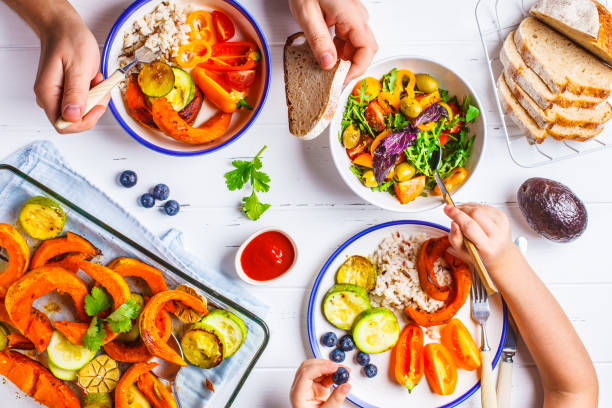

In [3]:
#View an image 
Image('drive/MyDrive/JunkFoodClassification/HealthyFood/HelloIMG1627738279448.jpeg')

##Preprocessing Images(turning images into Tensors)
To preprocess our images into Tensor we're going to write a function which does a few things:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, image
3. Turn our image (a jpeg) into Tensors
4. Normalize our image(convert color channel values from 0-255 to 0-1)
5. Resize the iamge to be a shape of (224,224)
6. Return the modified image

In [4]:
JunkFoodList = ["drive/MyDrive/JunkFoodClassification/JunkFood/" + images for images in tqdm(os.listdir("drive/MyDrive/JunkFoodClassification/JunkFood"))]
HealthyFoodList = ["drive/MyDrive/JunkFoodClassification/HealthyFood/" + images for images in tqdm(os.listdir("drive/MyDrive/JunkFoodClassification/HealthyFood"))]
JunkFoodList[:10]

100%|██████████| 709/709 [00:00<00:00, 439190.89it/s]


['drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627731654015.jpeg',
 'drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627731658360.jpeg',
 'drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627731661722.jpeg',
 'drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627731776927.jpeg',
 'drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627731976131.jpeg',
 'drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627732072863.jpeg',
 'drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627732092209.jpeg',
 'drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627732098646.jpeg',
 'drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627732102286.jpeg',
 'drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627732119294.jpeg']

In [5]:
print(len(JunkFoodList))
print(len(HealthyFoodList))

719
709


In [6]:
IMG_SIZE=224
X = []
y = []
image_list = [JunkFoodList, HealthyFoodList]
for each_list in image_list:
  category_index = image_list.index(each_list) # (0,1)
  for image_set in tqdm(each_list):
    image = tf.io.read_file(image_set)
    image = tf.io.decode_jpeg(image, channels = 3) # RGB
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = tf.image.resize(image, size =[IMG_SIZE, IMG_SIZE])
    X.append(image)
    y.append(category_index)
X[:1], y[:1]

100%|██████████| 709/709 [04:59<00:00,  2.37it/s]


([<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
  array([[[0.6191677 , 0.9590037 , 0.9732694 ],
          [0.67178875, 0.9728092 , 0.9915767 ],
          [0.6033214 , 0.93581444, 0.9606043 ],
          ...,
          [0.69857967, 0.96048415, 0.98401356],
          [0.72843057, 0.95924294, 0.9682065 ],
          [0.6542621 , 0.9539818 , 0.96364576]],
  
         [[0.64659864, 0.9413366 , 0.9601041 ],
          [0.66718686, 0.9445979 , 0.9521809 ],
          [0.63539416, 0.9406963 , 0.9559624 ],
          ...,
          [0.7020208 , 0.97332966, 0.99257725],
          [0.6829326 , 0.97088784, 0.9675265 ],
          [0.6887155 , 0.96022415, 0.97937185]],
  
         [[0.6847339 , 0.9580833 , 0.98205286],
          [0.66604644, 0.93271315, 0.9366347 ],
          [0.6636055 , 0.934754  , 0.9442778 ],
          ...,
          [0.66794634, 0.943597  , 0.95119995],
          [0.64783925, 0.96470594, 0.9686275 ],
          [0.6932573 , 0.9613247 , 0.97238904]],
  
         ...,
  
     

In [7]:
len(X), len(y)

(1428, 1428)

In [8]:
NUM_IMAGES = 110#@param{type:"slider", min:100,max :1000, step:100}

In [9]:
from sklearn.model_selection import train_test_split
# Split the images into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size = 0.33, random_state = 45)

In [10]:
len(X_train), len(X_val), len(y_train), len(y_val)

(956, 472, 956, 472)

In [11]:
print(y_train)

[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 

In [13]:
# Create batch dataset
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.batch(32)
validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(32)

In [14]:
len(train), len(validation)

(30, 15)

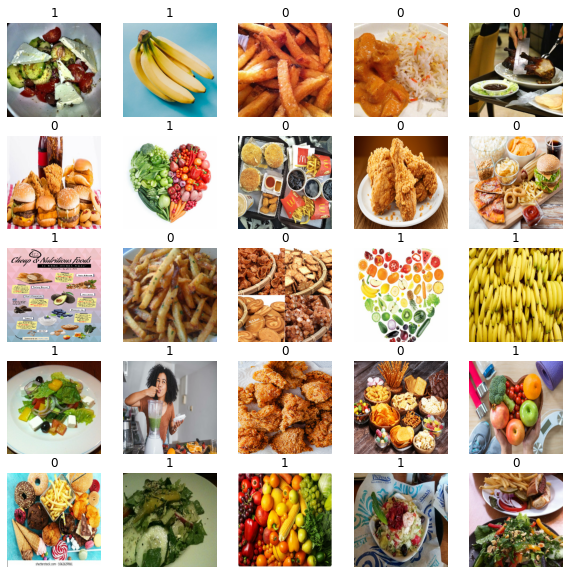

In [15]:
def show_25_images(images, label_set):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(label_set[i])
    # Turn gird lines off
    plt.axis("off")
show_25_images(X_train, y_train)

In [16]:
# Setup input shape to the model
INPUT_SHAPE = [IMG_SIZE, IMG_SIZE, 3] # Batch, height, width, colour channels

# setup output shpae of our model
OUTPUT_SHAPE = 1

# Setup model URL from TensorFlow Hub
MODEL_URL0 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"
MODEL_URL2 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
MODEL_URL3 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL, input_shape = INPUT_SHAPE), # Layer 1 (input layer)
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="sigmoid") # Layer 2 (output layer)
  ])


  # # Build the model
  # model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
  return model

In [18]:
model = create_model()
# Compile the model
model.compile(
  loss=tf.keras.losses.BinaryCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
  optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
  metrics=["accuracy"] # We'd like this to go up
)
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 16)                16032     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 5,448,762
Trainable params: 16,049
Non-trainable params: 5,432,713
_________________________________________________________________


##Creating callbacks
Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which help track our models progress and another for early stopping which prevents our model from training for too long.

##TensorBoard Callback
To setup a TensorBoard callback, we need to do three things

Load the TensorBoard notebook extension
Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function
Visualize our models training logs iwth the %tensorboard magic function

In [19]:
%load_ext tensorboard

In [20]:
import datetime

# Create a function to build a TensorBoard Callback
def create_tensorboard_callback():
  logdir = os.path.join("drive/MyDrive/JunkFoodClassification/log",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

##Early Stopping Callback
Stop model from overfitting by stopping traniing if a certain evaluation metric stops improving

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience  = 5)

In [22]:
NUM_EPOCHS = 30 #@param {type:"slider", min:10, max:100, step:10}

In [23]:
tensorboard = create_tensorboard_callback()

# Fit the model to the data passing it the callbacks we created
history = model.fit(x= train,
          epochs=NUM_EPOCHS,
          validation_data= validation,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])

Epoch 1/30
30/30 [==============================] - 39s 201ms/step - loss: 0.4117 - accuracy: 0.7918 - val_loss: 0.2807 - val_accuracy: 0.9004
Epoch 2/30
30/30 [==============================] - 3s 104ms/step - loss: 0.1602 - accuracy: 0.9456 - val_loss: 0.2430 - val_accuracy: 0.9153
Epoch 3/30
30/30 [==============================] - 3s 105ms/step - loss: 0.1030 - accuracy: 0.9707 - val_loss: 0.2440 - val_accuracy: 0.9258
Epoch 4/30
30/30 [==============================] - 3s 102ms/step - loss: 0.0764 - accuracy: 0.9801 - val_loss: 0.2412 - val_accuracy: 0.9280
Epoch 5/30
30/30 [==============================] - 3s 102ms/step - loss: 0.0579 - accuracy: 0.9874 - val_loss: 0.2401 - val_accuracy: 0.9237
Epoch 6/30
30/30 [==============================] - 3s 105ms/step - loss: 0.0448 - accuracy: 0.9927 - val_loss: 0.2410 - val_accuracy: 0.9237
Epoch 7/30
30/30 [==============================] - 3s 105ms/step - loss: 0.0349 - accuracy: 0.9948 - val_loss: 0.2369 - val_accuracy: 0.9280
Epoch

In [24]:
%tensorboard --logdir drive/MyDrive/JunkFoodClassification/log

<IPython.core.display.Javascript object>

##Making and evaluating predictions using a trained model

In [ ]:
model.score()

AttributeError: ignored

In [ ]:
prediction = model.evaluate(train, validation, verbose = 1)
prediction

ValueError: ignored

In [ ]:
#Make predictions on the validation data(not used to train on)
score = model.evaluate(train, validation, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

ValueError: ignored

In [ ]:
predictions.shape

(472, 1)

In [ ]:
# First prediction
index = 50
print(predictions[0])
print(f"Max value(probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")

[0.99360013]
Max value(probability of prediction): 0.2780172824859619
Sum: 0.2780172824859619
Max index: 0


In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(label)
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(validation)
val_images[0], val_labels[0]

(array([[[0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         ...,
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785]],
 
        [[0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         ...,
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785]],
 
        [[0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         ...,
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785]],
 
        ...,
 
        [[0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         [0.9960785, 0.9960785, 0.9960785],
         .

## Saving and Reloading a Trained Model


In [ ]:
# Create a function to save a model:
def save_model(model, suffix = None):
  """
  Saves a given model in a models directory and appends a suffix(string)
  """
  modeldir = os.path.join("drive/MyDrive/JunkFoodClassification/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix +".h5" #the format of model
  print(f"Saving model to: {model_path}")
  model.save(model_path)
  return model_path

In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Load from a specified path
  """
  print(f"Loading save model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects = {"KerasLayer": hub.KerasLayer})
  return model

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix = "AdamSigmoidModel")

Saving model to: drive/MyDrive/JunkFoodClassification/models/20210804-15371628091458-AdamSigmoidModel.h5
